# Imports

In [1]:
import mysql.connector
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np

# Leitura de dados

In [2]:
def carrega_conexao():
    load_dotenv()
    env = os.environ

    # Connect to MySQL server
    localhost = env.get('MYSQL_HOST')
    user = env.get('MYSQL_USER')
    password = env.get('MYSQL_PASSWORD')

    conexao = mysql.connector.connect(user=user, password=password, host=localhost)
    return conexao

In [3]:
# Use a função carrega_conexao para obter a conexão
conexao_mysql = carrega_conexao()

# Converta a conexão MySQL para uma conexão SQLAlchemy
engine = create_engine('mysql+mysqlconnector://', creator=lambda: conexao_mysql)

# Substitua 'select * from fase4_petroleo.petroleo' pela sua consulta SQL
query = 'select * from fase4_petroleo.petroleo'

# Use a engine para ler os dados da tabela
df = pd.read_sql(query, con=engine)

# Não se esqueça de fechar a conexão quando terminar de usá-la
conexao_mysql.close()

In [4]:
df.set_index('data', inplace=True)
df

,preco
data,
2024-01-22,81.70
2024-01-19,80.71
2024-01-18,81.04
2024-01-17,78.88
2024-01-16,80.15
...,...
1987-05-26,18.63
1987-05-25,18.60
1987-05-22,18.55


In [5]:
#inverter a ordem do dataframe
df = df.iloc[::-1]

# Modelos

In [6]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings

def preprocess_data(df, train_data_size, forecast_steps):
    df = df.sort_index(ascending=True)
    df = df.asfreq('B')
    train_data = df[-train_data_size:-forecast_steps]
    return df, train_data

def train_arima_model(train_data):
    arima_model = ARIMA(train_data, order=(2, 1, 2))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")  # Silence ConvergenceWarning
        arima_model_trained = arima_model.fit()
    return arima_model_trained

def forecast_arima_model(arima_model_trained, last_date, forecast_steps):
    arima_forecast = arima_model_trained.get_forecast(steps=forecast_steps)
    arima_pred_mean = arima_forecast.predicted_mean.rename('ARIMA(2,1,2) Predictions')
    arima_pred_mean.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
    return arima_pred_mean

def train_sarima_model(train_data):
    sarima_model = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=(1, 1, 1, 5))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")  # Silence ConvergenceWarning
        sarima_model_trained = sarima_model.fit()
    return sarima_model_trained

def forecast_sarima_model(sarima_model_trained, last_date, forecast_steps):
    sarima_forecast = sarima_model_trained.get_forecast(steps=forecast_steps)
    sarima_pred_mean = sarima_forecast.predicted_mean.rename('SARIMA(2,1,2)(1,1,1,5) Predictions')
    sarima_pred_mean.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
    return sarima_pred_mean

def calculate_metrics(predictions, actual_values):
    mae = np.mean(np.abs(predictions - actual_values))
    mse = np.mean((predictions - actual_values)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
    return mae, mse, rmse, mape

def plot_predictions(df, train_data_size, plot_data_size, actual_values, arima_pred_mean, sarima_pred_mean):
    plt.figure(figsize=(12, 6))
    plt.plot(df.loc[df.index[-plot_data_size:]], label=f'Last {train_data_size} Days Data', marker='o', linestyle='-', color='black')
    plt.plot(arima_pred_mean, label='ARIMA Predictions', linestyle='dashed', color='blue', marker='o')
    plt.plot(sarima_pred_mean, label='SARIMA Predictions', linestyle='dashed', color='green', marker='o')
    
    plt.yticks(np.arange(55, 101, step=5))
    
    plt.legend()
    plt.title(f'ARIMA and SARIMA Predictions for the Last {train_data_size} Days')
    plt.show()

def time_series_pipeline(data, train_data_size, forecast_steps, plot_data_size, plot=False):
    df, train_data = preprocess_data(data, train_data_size, forecast_steps)

    arima_model_trained = train_arima_model(train_data)
    last_date = train_data.index[-1]
    arima_pred_mean = forecast_arima_model(arima_model_trained, last_date, forecast_steps)

    sarima_model_trained = train_sarima_model(train_data)
    sarima_pred_mean = forecast_sarima_model(sarima_model_trained, last_date, forecast_steps)

    actual_values = df.loc[df.index[-forecast_steps:], 'preco'].values  # Replace 'preco' with the actual column name

    mae_arima, mse_arima, rmse_arima, mape_arima = calculate_metrics(arima_pred_mean, actual_values)
    mae_sarima, mse_sarima, rmse_sarima, mape_sarima = calculate_metrics(sarima_pred_mean, actual_values)

    if plot:
        plot_predictions(df, train_data_size, plot_data_size, actual_values, arima_pred_mean, sarima_pred_mean)
        print("ARIMA Metrics:")
        print(f"MAE: {mae_arima:.2f}")
        print(f"MSE: {mse_arima:.2f}")
        print(f"RMSE: {rmse_arima:.2f}")
        print(f"MAPE: {mape_arima:.2f}%")

        print("\nSARIMA Metrics:")
        print(f"MAE: {mae_sarima:.2f}")
        print(f"MSE: {mse_sarima:.2f}")
        print(f"RMSE: {rmse_sarima:.2f}")
        print(f"MAPE: {mape_sarima:.2f}%")

    return mae_arima, mae_sarima

def find_best_parameters(data, train_intervals, forecast_intervals, plot_data_size):
    best_mae = float('inf')
    best_train_data_size = None
    best_forecast_steps = None
    best_model = None

    for train_interval in tqdm(train_intervals, desc="Training ARIMA and SARIMA"):
        #remove from forecast_intervals the values that are greater than train_interval
        forecast_intervals_copy = [x for x in forecast_intervals if x < train_interval]
        for forecast_interval in tqdm(forecast_intervals_copy, desc="Forecasting"):
            train_data_size = train_interval
            forecast_steps = forecast_interval

            mae_arima, mae_sarima = time_series_pipeline(data, train_data_size, forecast_steps, plot_data_size)

            if mae_arima < best_mae:
                best_mae = mae_arima
                best_train_data_size = train_data_size
                best_forecast_steps = forecast_steps
                best_model = 'ARIMA'

            if mae_sarima < best_mae:
                best_mae = mae_sarima
                best_train_data_size = train_data_size
                best_forecast_steps = forecast_steps
                best_model = 'SARIMA'

    time_series_pipeline(data, best_train_data_size, best_forecast_steps, plot_data_size, plot=True)

    print(f"Best Parameters - Train Interval: {best_train_data_size} days, Forecast Interval: {best_forecast_steps} days")
    print(f"Best Model: {best_model}")
    print(f"Best MAE: {best_mae:.2f}")


Training ARIMA and SARIMA: 100%|██████████| 8/8 [03:07<00:00, 23.48s/it]


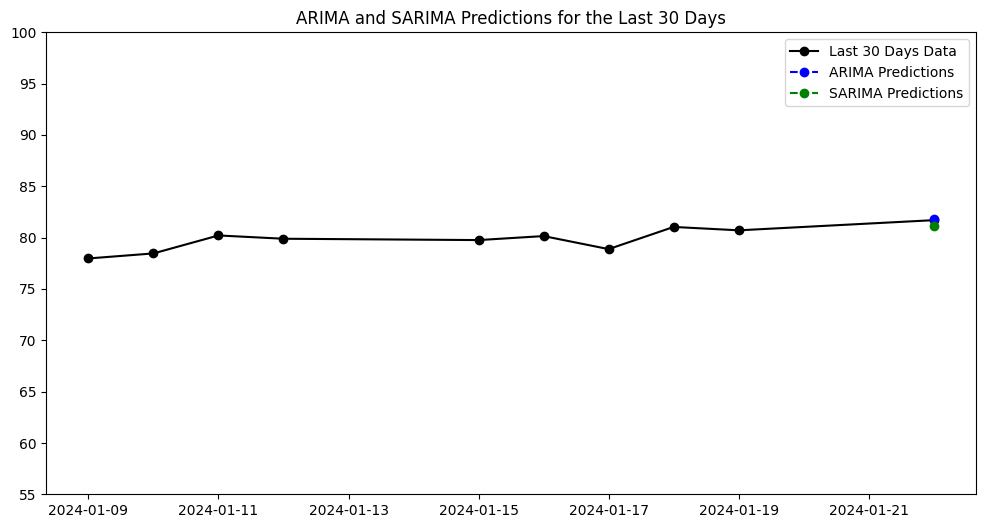

ARIMA Metrics:
MAE: 0.09
MSE: 0.01
RMSE: 0.09
MAPE: 0.11%

SARIMA Metrics:
MAE: 0.54
MSE: 0.29
RMSE: 0.54
MAPE: 0.66%
Best Parameters - Train Interval: 30 days, Forecast Interval: 1 days
Best Model: ARIMA
Best MAE: 0.09


In [7]:
# Example usage:
train_intervals = [30, 90, 180, 365, 730, 1825, 3650, len(df)]  # Intervals in days for training
forecast_intervals = [1, 2, 5, 10, 30]  # Intervals in days for forecasting

find_best_parameters(df, train_intervals, forecast_intervals, plot_data_size=10)

In [12]:
best_train_data_size = 30
best_forecast_steps = 1

In [13]:
#train the best model and save it
df, train_data = preprocess_data(df, best_train_data_size, best_forecast_steps)
sarima_model_trained = train_sarima_model(train_data)
sarima_model_trained.save('..\modelos\sarima_model_trained.pkl')